In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shap
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold

## Classifying American League Starters vs National League Starters

MLB Baseball teams are divided into two leagues: The American League (AL) and the National League (NL). Unlike in the NFL where the division between AFC and NFC purely affects standings, in baseball there are differing rules in the AL and NL. These rules mainly center around the offensive role of pitchers in the line-up.

In the National League, pitchers participate in the offensive part of the game (batting) the same as any other player would. 
In the American League, pitchers do not bat, and instead there is a position known as "Designated Hitter" who bats in the pitcher's place.

Debate has long raged with solid arguments for both sides about whether the AL or NL have better pitchers. Our goal here is not to determine which pitchers are better, but to see if we can build a classifier that can accurately predict which league a pitcher belongs to based on their stats.



Below we create a pipeline for training a boosted trees model using Xgboost. This model will include calculating: 
* a ROC Curve - encodes information on how decision thresholds trade off between False Positive Rates and True Positive Rates
* AUC - The area under the ROC curve.
* Feature Importance - Which statistics have the largest effect on our model.

In [2]:
def create_model(x_train, y_train, x_test, y_test):
    # Initialize model
    xg_reg = xgb.XGBRegressor(
        objective="binary:logistic",
        colsample_bytree=0.3,
        learning_rate=0.1,
        max_depth=5,
        alpha=10,
        n_estimators=50,
    )
    # Fit model
    xg_reg.fit(x_train, y_train)

    # Make Predictions
    predictions = xg_reg.predict(x_test)

    # Extract ROC Curve data
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, predictions, drop_intermediate=False
    )
    print("AUC: {}".format(metrics.auc(fpr, tpr)))

    # Plot the ROC Curve
    temp_thresh = thresholds
    temp_thresh[0] = thresholds[0] - 1
    plt.scatter(fpr, tpr, c=temp_thresh, cmap=cm.rainbow)
    plt.suptitle("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    cbar = plt.colorbar()
    cbar.set_label("Decision Threshold")
    plt.show()

    # Plot Feature Importance
    explainer = shap.TreeExplainer(xg_reg)
    shap_values = explainer.shap_values(x_train)
    shap.summary_plot(shap_values, x_train)

    return {
        "model": xg_reg,
        "auc": metrics.auc(fpr, tpr),
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
    }

In [3]:
df = pd.read_csv("Pitching.csv")
df.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')

In [4]:
# Restrict attention to data year 2000 and after.
df = df[df["yearID"] > 1999]

Unfortunately, the data does not provide info regarding what kind of pitcher the player is. Given that the goals, methods, and statistics of starters, middle-relief, and closers tend to be very different, it is a good idea to attempt to separate them in the data. For now let's focus on starting pitchers. 

We will only consider pitchers who have started in at **least 90% of the games they played in** and have **started in at least 5 games**. 

In [5]:
# Isolate Starting Pitchers.
df = df[df["GS"] / df["G"] >= 0.9]
df = df[df["GS"] >= 5]

In [6]:
# For the purposes of visualization, split the data into NL and AL dataframes.
df_NL = df[df["lgID"] == "NL"]
df_AL = df[df["lgID"] == "AL"]

# Restrict our attention to quantitative statistics.
quantitative_statistics = [
    "W",
    "L",
    "G",
    "GS",
    "CG",
    "SHO",
    "SV",
    "IPouts",
    "H",
    "ER",
    "HR",
    "BB",
    "SO",
    "BAOpp",
    "ERA",
    "IBB",
    "WP",
    "HBP",
    "BK",
    "BFP",
    "GF",
    "R",
    "SH",
    "SF",
    "GIDP",
]

descriptive_titles = {
    "W": "Wins",
    "L": "Losses",
    "G": "Games",
    "GS": "Games Started",
    "CG": "Complete Games",
    "SHO": "Shutouts",
    "SV": "Saves",
    "IPouts": "Outs Pitched",
    "H": "Hits",
    "ER": "Earned Runs",
    "HR": "Home Runs",
    "BB": "Walks",
    "SO": "Strikeouts",
    "BAOpp": "Opponent Batting Average",
    "ERA": "Earned Run Average",
    "IBB": "Intentional Walks",
    "WP": "Wild Pitches",
    "HBP": "Batters Hit By Pitch",
    "BK": "Balks",
    "BFP": "Batters Faced By Pitcher",
    "GF": "Games Finished",
    "R": "Runs Allowed",
    "SH": "Sacrifices by Opposing Batters",
    "SF": "Sac Flies by Opposing Batters",
    "GIDP": "Grounded Into Double Plays by Opposing Batters",
}

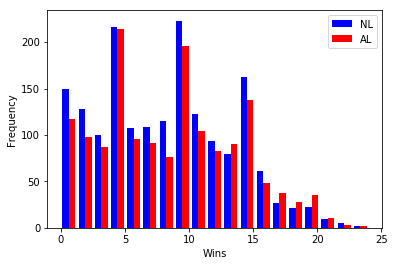

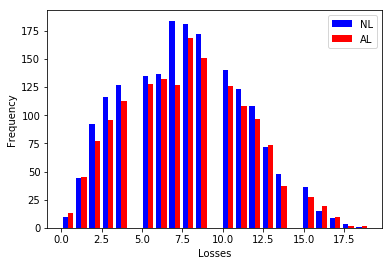

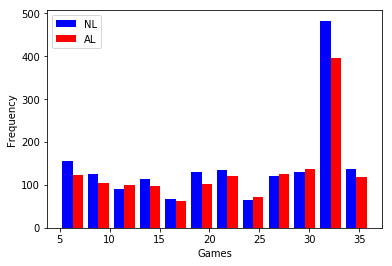

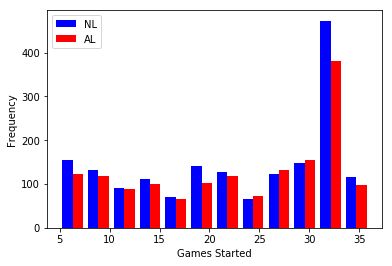

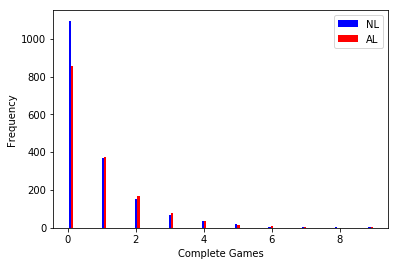

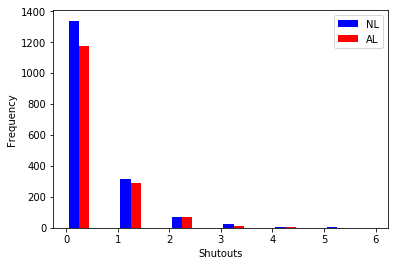

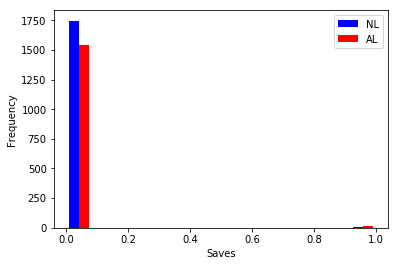

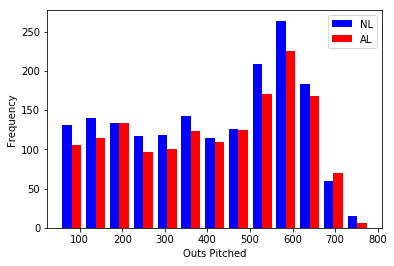

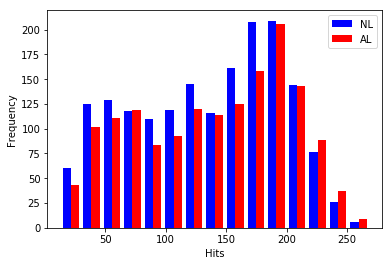

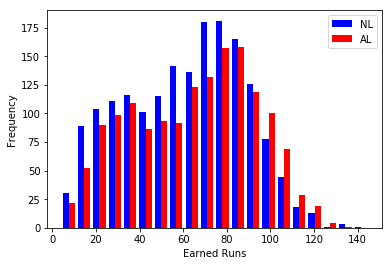

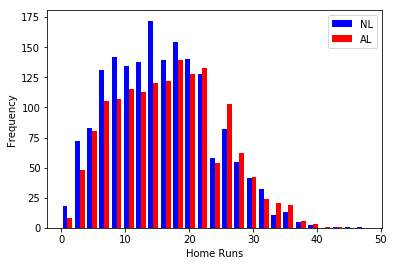

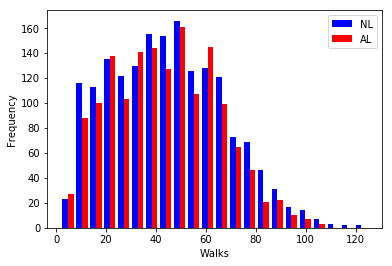

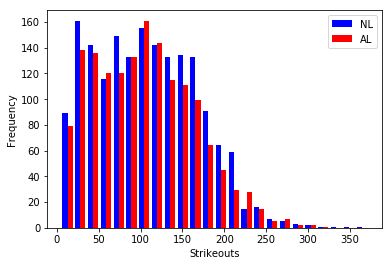

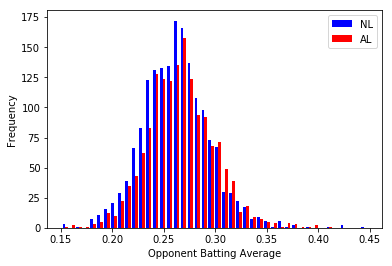

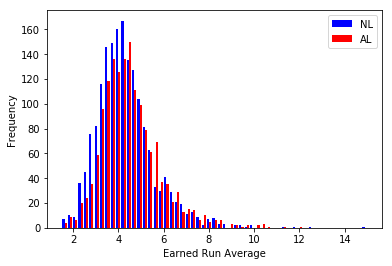

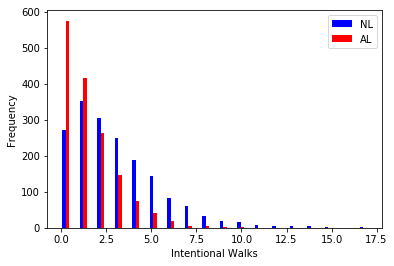

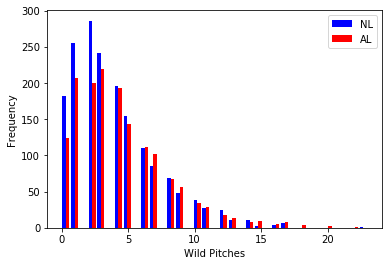

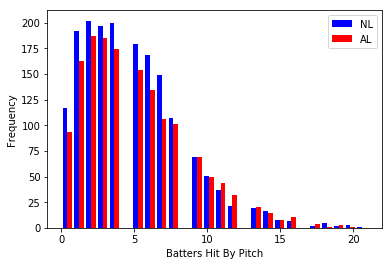

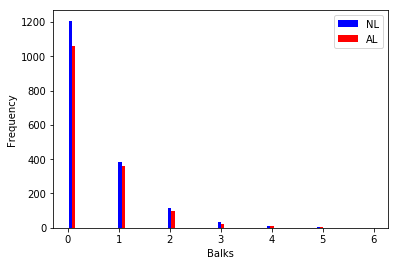

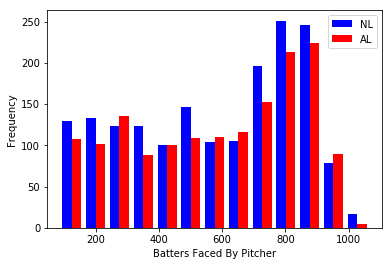

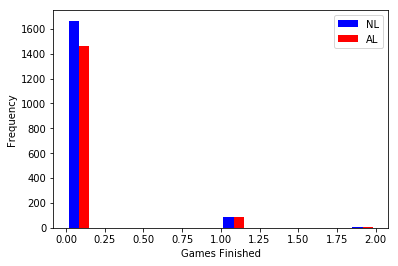

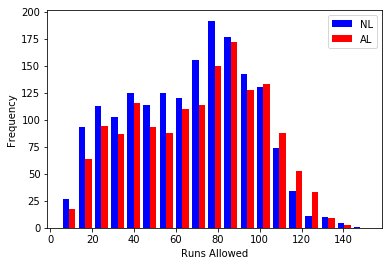

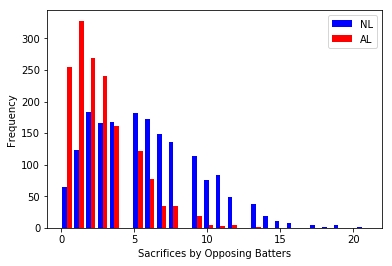

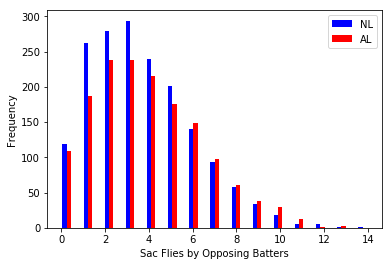

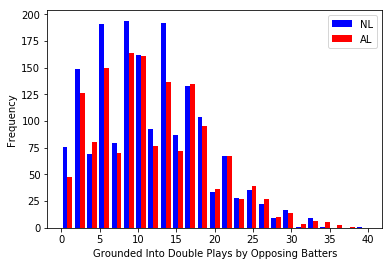

In [7]:
# Histograms comparing statistics for NL and AL starting pitchers.

for column_title in quantitative_statistics:
    plt.hist(
        [df_NL[column_title], df_AL[column_title]],
        bins="auto",
        color=["blue", "red"],
        label=["NL", "AL"],
    )
    plt.legend(prop={"size": 10})
    plt.xlabel(descriptive_titles[column_title])
    plt.ylabel("Frequency")
    plt.show()

Some interesting differences occur.
* The National League seems to have a higher prevalence of sacrificial batting (bunting, for example). This can mostly be explained by the fact that it is very common for NL pitchers to use their at-bats to bunt in an attempt to advance runners. In the AL pitchers do not bat, and therefore while bunting is used, it comes up less often.
* The National League pitchers also have more intentional walks. This one surprised me. Intentional walks are typically reserved for the big, scary batters on the opposing team. Often the fourth batter in the line-up. So does the National League have scarier batters? That sounds like a fun project to tackle in the future.

We expect that in any model that is capable at predicting the league a pitcher belongs to, sacrificial hits and intentional walks will play an important role.

For now, let's get back to training the model.

In [8]:
# Restrict the training data to quantitative statistics.
X = df[['W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP']]
y = df['lgID']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and test sets.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

[13:12:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8747886650985004


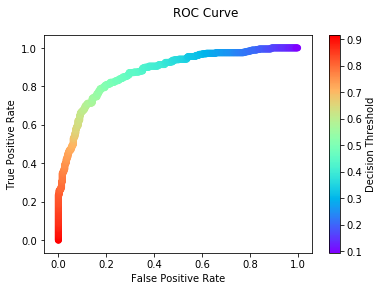

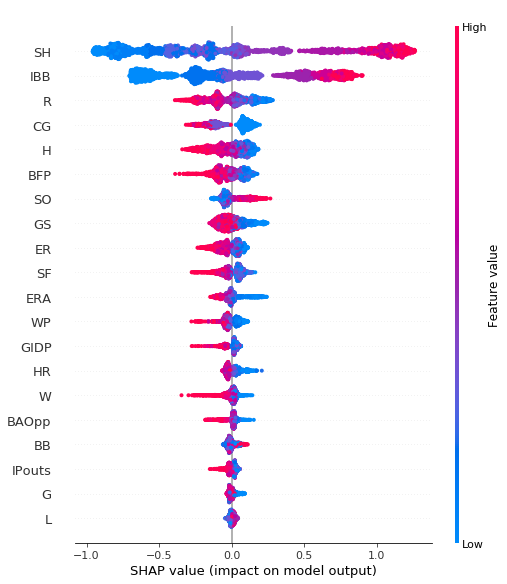

In [9]:
model_dict = create_model(x_train, y_train, x_test, y_test)

Understanding the above output:
* **How the Model makes decisions:** The model we trained doesn't actually output 'AL' or 'NL', but rather a number between 0 and 1. We then must decide whether to round that number up to 1 (where we will conclude 'AL') or down to 0 (where we will conclude 'NL'). This is done by choosing a threshold. Outputs above the threshold are rounded up to 1 and outputs less than the threshold are rounded down.
* **ROC Curve:** The ROC curve is created by plotting the TPR (true positive rate) vs the FPR (false positive rate) for various choices of the threshold that was previously mentioned. A point on the ROC Curve is colored according to the threshold it corresponds to.
* **AUC:** This stands for "Area Under Curve" and is the area under the ROC Curve. The larger the AUC, the better, as this generally means that one can choose a threshold that gives a high TPR without also gaining a high FPR.
* The AUC and ROC curve look great. It is generally accepted that an AUC in the range 0.8-0.9 is quite good, and about 0.9 is excellent.
* Unsurprisingly 'SH' and 'IBB' (sacrificial hits and intentional walks) are at the top in terms of importance, just as our exploration before suggested they might be.

Below cross-validation is implemented to ensure robustness of the model. Overall, I am pleased with the performance of the model with the average AUC below clocking in at around 0.87.

[13:12:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8662700059960333


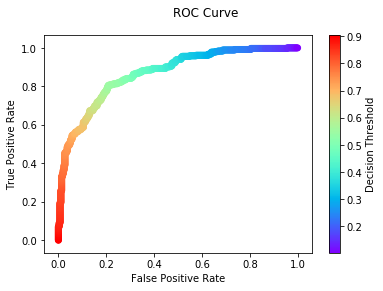

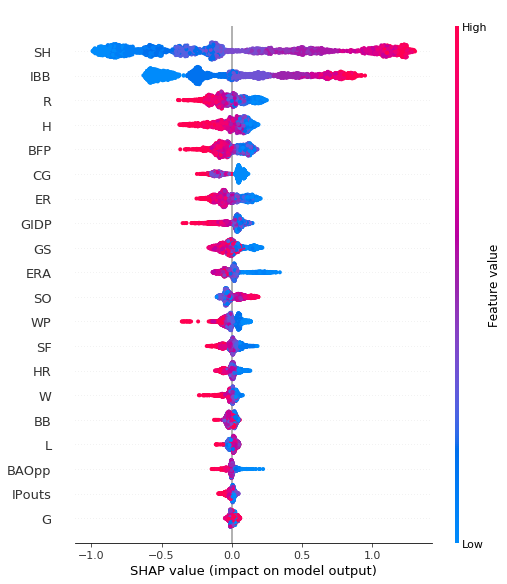

[13:12:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8662700059960333


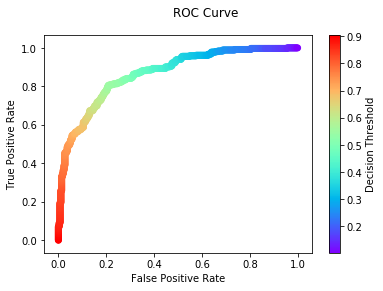

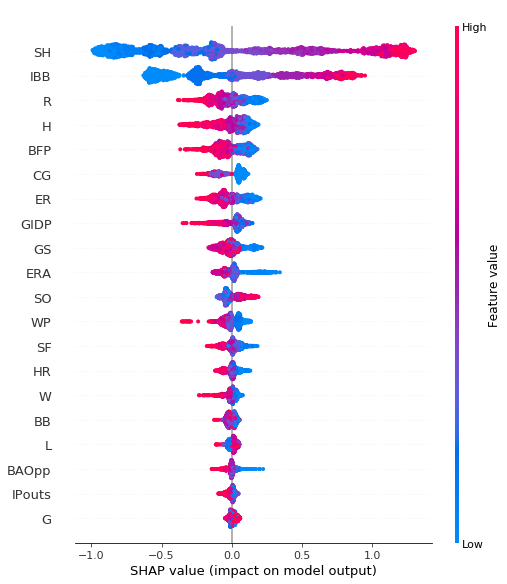

[13:12:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8807093108504399


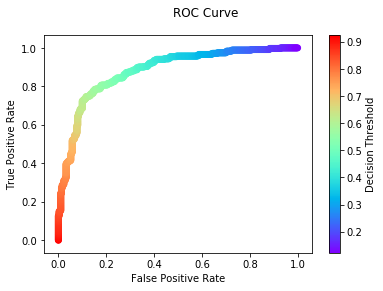

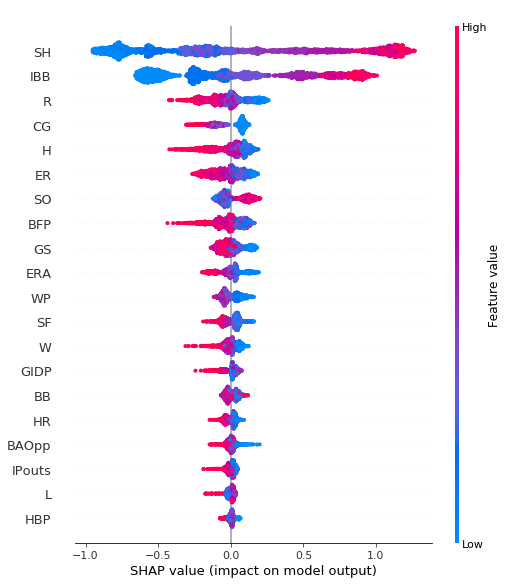

[13:12:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8807093108504399


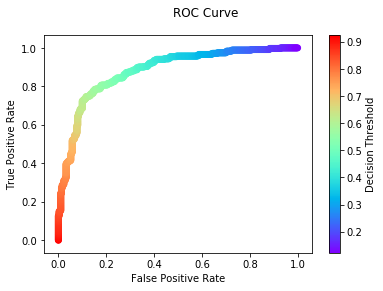

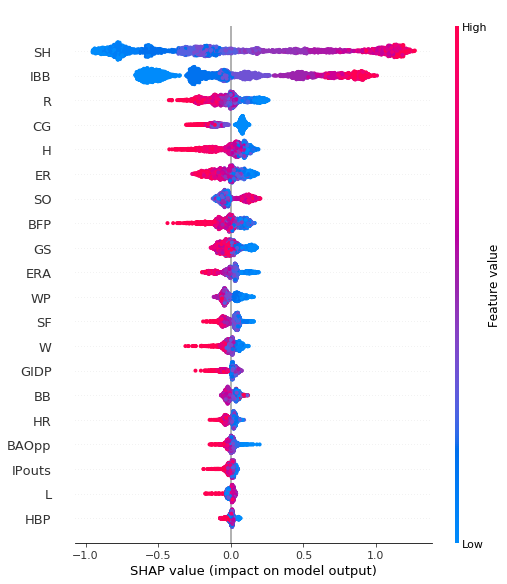

[13:12:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8892479057350641


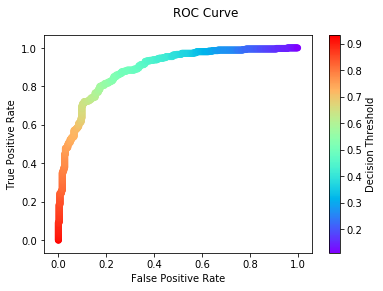

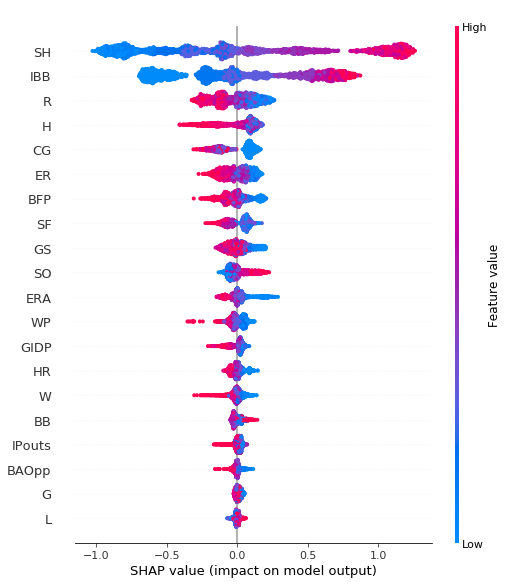

[13:12:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8892479057350641


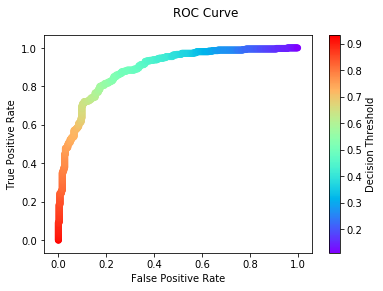

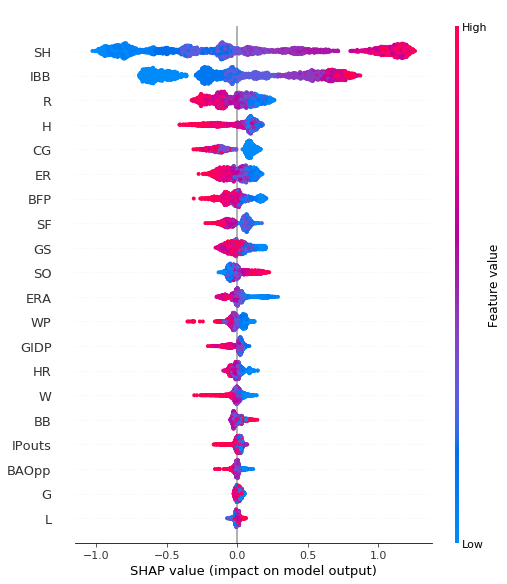

[13:12:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.871818917328626


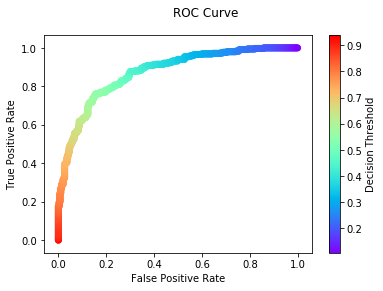

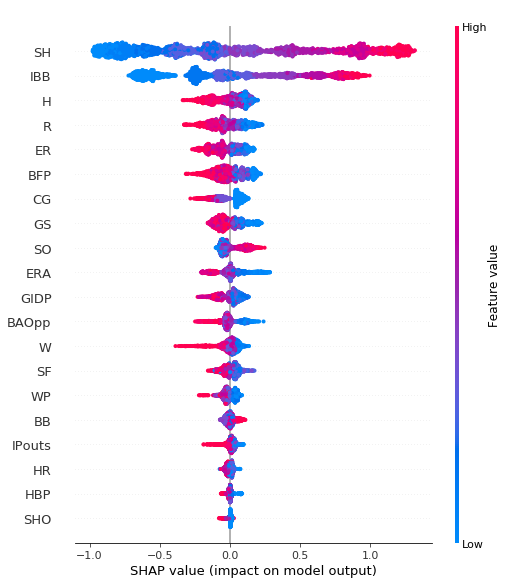

[13:12:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.871818917328626


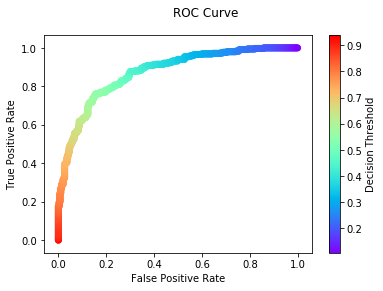

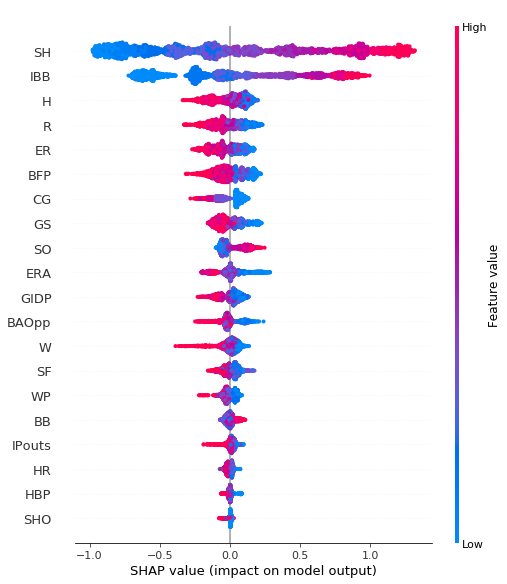

[13:12:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8392582488006738


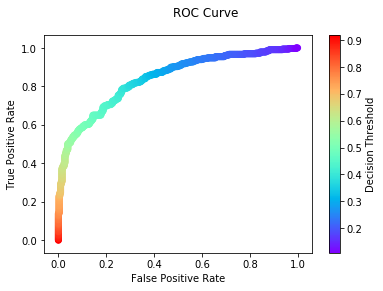

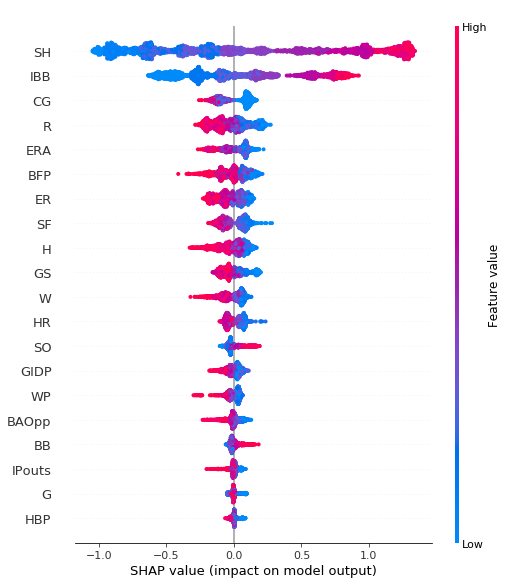

[13:12:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8392582488006738


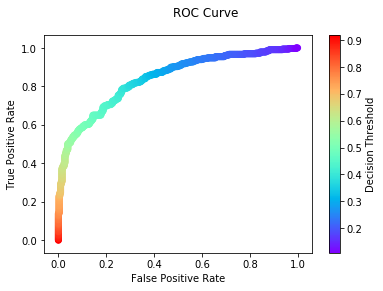

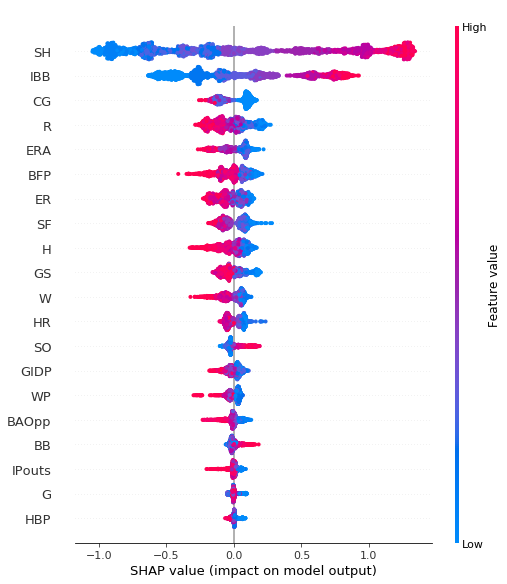

In [10]:
kf = KFold(n_splits=5)
cv_results = []
for train_index, test_index in kf.split(X):
    x_train, x_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    model, model_auc, false_pos, true_pos, thresholds = create_model(
        x_train, y_train, x_test, y_test
    )
    cv_results.append(create_model(x_train, y_train, x_test, y_test))

In [11]:
print(f"Average AUC: {np.average([x['auc'] for x in cv_results]):.2f}\u00B1{np.std([x['auc'] for x in cv_results]):.2f}")

Average AUC: 0.87±0.02
